# QURI SDK Showcase

## Easy installation

Requires Python3.10 or later. Optionally define a virtual environment

In [ ]:
python -m venv .venv
source .venv/bin/activate

then install

In [ ]:
pip install quri-parts quri-algo quri-vm

## Easy definition of quantum circuits

In [46]:
from quri_parts.circuit import QuantumCircuit

qubit_count = 2

circuit = QuantumCircuit(qubit_count)  # create an empty quantum circuit with 2 qubits
circuit.add_H_gate(0)  # Add Hadamard gate on 0'th qubit
circuit.add_CNOT_gate(0,1)

circuit.draw()

   ___          
  | H |         
--|0  |-----●---
  |___|     |   
           _|_  
          |CX | 
----------|1  |-
          |___| 


## Easy sampling

Circuits have a sample method

In [47]:
circuit.sample(1000)  # noise-free sampling simulation using Qulacs

Counter({0: 504, 3: 496})

## Using virtual machines

We use virtual machines with our algorithms. These virtual machines mimic quantum device architectures (with or without error correction) and return results from estimations or sampling experiments.

They can be combined with out algorithm suite to run phase estimation algorithms with accurate simulated results or skip the algorithm execution in favour of resource estimation for the algorithms

In [48]:
from quri_vm import VM
from quri_parts.backend.devices import clifford_t_device, star_device
from quri_parts.backend.units import TimeUnit, TimeValue

physical_error_rate=1.0e-5
d=7
qec_cycle_us=1.0
delta_sk=1.0e-5
mode_block="compact"

clifford_t_device_property = clifford_t_device.generate_device_property(
        qubit_count=qubit_count,
        code_distance=d,
        qec_cycle=TimeValue(qec_cycle_us, TimeUnit.MICROSECOND),
        delta_sk=delta_sk,
        physical_error_rate=physical_error_rate,
        mode_block=mode_block
    )
star_device_property = star_device.generate_device_property(
        qubit_count=qubit_count,
        code_distance=d,
        qec_cycle=TimeValue(qec_cycle_us, TimeUnit.MICROSECOND),
        physical_error_rate=physical_error_rate,
    )
ftqc_vm = VM.from_device_prop(clifford_t_device_property)
star_vm = VM.from_device_prop(star_device_property)

Using this we can sample

In [49]:
ftqc_vm.sample(circuit, shots=1000)

Counter({0: 512, 3: 488})

or analyze a quantum circuit

In [50]:
from pprint import pprint

pprint(ftqc_vm.analyze(circuit))
pprint(star_vm.analyze(circuit))

AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=2,
              gate_count=2,
              depth=2,
              latency=TimeValue(value=35000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.999999994290949)
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=2,
              gate_count=2,
              depth=2,
              latency=TimeValue(value=35000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.9999999983688426)


## Generating circuits with circuit factories

We have circuit factories that can generate complex circuits such as time-evolution circuits, etc. We can use these to generate time-evolution circuits any generic qubit Hamiltonian

In [51]:
from quri_parts.core.operator import Operator, pauli_label

from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterTimeEvolutionCircuitFactory
from quri_algo.problem import QubitHamiltonian

N_TROTTER=2
EVOLUTION_TIME=0.1
QUBIT_COUNT=4

# Hamiltonian operator
hamiltonian = Operator()
hamiltonian.add_term(pauli_label("X0 X1"), 1.0)
hamiltonian.add_term(pauli_label("X1 X2"), 1.0)
hamiltonian.add_term(pauli_label("X2 X3"), 1.0)
hamiltonian.add_term(pauli_label("Z0"), -1.0)
hamiltonian.add_term(pauli_label("Z1"), -1.0)
hamiltonian.add_term(pauli_label("Z2"), -1.0)
hamiltonian.add_term(pauli_label("Z3"), -1.0)

# Input for quantum algorithms
hamiltonian_input = QubitHamiltonian(QUBIT_COUNT, hamiltonian)

# Time evolution operator
time_evo_circuit_factory = TrotterTimeEvolutionCircuitFactory(hamiltonian_input, n_trotter=N_TROTTER)

time_evo_circuit = time_evo_circuit_factory(EVOLUTION_TIME)  # generate time evolution circuit and draw it
time_evo_circuit.draw()

   ___     ___             ___     ___                  
  |PR |   |PR |           |PR |   |PR |                 
--|0  |---|3  |-----------|7  |---|10 |-----------------
  |   |   |___|           |   |   |___|                 
  |   |    ___     ___    |   |    ___     ___          
  |   |   |PR |   |PR |   |   |   |PR |   |PR |         
--|   |---|1  |---|4  |---|   |---|8  |---|11 |---------
  |___|   |   |   |___|   |___|   |   |   |___|         
          |   |    ___     ___    |   |    ___     ___  
          |   |   |PR |   |PR |   |   |   |PR |   |PR | 
----------|   |---|2  |---|5  |---|   |---|9  |---|12 |-
          |___|   |   |   |___|   |___|   |   |   |___| 
                  |   |    ___            |   |    ___  
                  |   |   |PR |           |   |   |PR | 
------------------|   |---|6  |-----------|   |---|13 |-
                  |___|   |___|           |___|   |___| 


Each VM instance has a transpiler that it uses to transform circuits like the above into gate-based operations that can be executed on the device. In this case the pauli-rotations will be expanded into concrete gates.

In [52]:
transpiled_circuit = star_vm.transpile(time_evo_circuit)  # transpile the circuit to the device
transpiled_circuit.draw()  # draw the transpiled circuit

   ___     ___     ___     ___     ___     ___     ___                          
  | H |   |CX |   |RZ |   |CX |   | H |   |RZ |   | H |                         
--|0  |---|2  |---|3  |---|4  |---|5  |---|21 |---|25 |-------------------------
  |___|   |___|   |___|   |___|   |___|   |___|   |___|                         
   ___      |               |      ___     ___     ___     ___     ___     ___  
  | H |     |               |     | H |   | H |   |CX |   |RZ |   |CX |   | H | 
--|1  |-----●---------------●-----|6  |---|7  |---|9  |---|10 |---|11 |---|12 |-
  |___|                           |___|   |___|   |___|   |___|   |___|   |___| 
   ___                                              |               |      ___  
  | H |                                             |               |     | H | 
--|8  |---------------------------------------------●---------------●-----|13 |-
  |___|                                                                   |___| 
   ___                      

## Support for external SDKs

We interface with a range of SDKs for example qiskit

In [20]:
pip install quri-parts[qiskit]


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


We can use qiskit for various tasks, including transpilation

In [53]:

from quri_parts.qiskit.circuit.transpile import QiskitTranspiler

OPTIMIZATION_LEVEL = 3

transpiler = QiskitTranspiler(
    basis_gates=["CNOT", "H", "S", "Sdag", "RZ"],
    optimization_level=OPTIMIZATION_LEVEL
    )
optimized_circuit = transpiler(transpiled_circuit)
optimized_circuit.draw()  # draw the optimized circuit

   ___     ___     ___     ___     ___     ___     ___                          
  | H |   |CX |   |RZ |   |CX |   | H |   |RZ |   | H |                         
--|0  |---|2  |---|3  |---|4  |---|5  |---|6  |---|7  |-------------------------
  |___|   |___|   |___|   |___|   |___|   |___|   |___|                         
   ___      |               |      ___     ___     ___     ___     ___     ___  
  | H |     |               |     |CX |   |RZ |   |CX |   | H |   |RZ |   | H | 
--|1  |-----●---------------●-----|9  |---|10 |---|11 |---|12 |---|13 |---|14 |-
  |___|                           |___|   |___|   |___|   |___|   |___|   |___| 
   ___                              |               |                           
  | H |                             |               |                           
--|8  |-----------------------------●---------------●-------●---------------●---
  |___|                                                     |               |   
   ___                      

The transpiler we have defined above interfaces with quri-parts circuits, so we don't need to convert circuits to qiskit circuits first.

Let's briefly compare

In [54]:
print("Depth of transpiled circuit: ", transpiled_circuit.depth)
print("Depth of optimized circuit: ", optimized_circuit.depth)

Depth of transpiled circuit:  27
Depth of optimized circuit:  21


## Tools for circuit inspection

We can verify the two circuits are the same by computing the Hilbert-Schmidt test

In [55]:
from quri_algo.core.cost_functions import HilbertSchmidtTest

hs_test = HilbertSchmidtTest(ftqc_vm.estimate)  # uses the ftqc_vm as backend
print("The Hilbert-Schmidt cost is: ", hs_test(transpiled_circuit, optimized_circuit).value.real)  # compare the transpiled circuit and the optimized circuit

The Hilbert-Schmidt cost is:  -3.0531133177191805e-16


## Easy to use quantum algorithms

We can import ready made algorithms and run them easily

In [56]:
from quri_parts.algo.ansatz import Z2SymmetryPreservingReal

from quri_algo.algo.compiler import QAQC

REPS=10

ansatz=Z2SymmetryPreservingReal(qubit_count,reps=REPS)
qaqc=QAQC(cost_fn=hs_test)  # create a QAQC instance with the cost function we defined earlier

compilation_result = qaqc.run(time_evo_circuit_factory,ansatz,evolution_time=EVOLUTION_TIME)

We can plot the cost history too

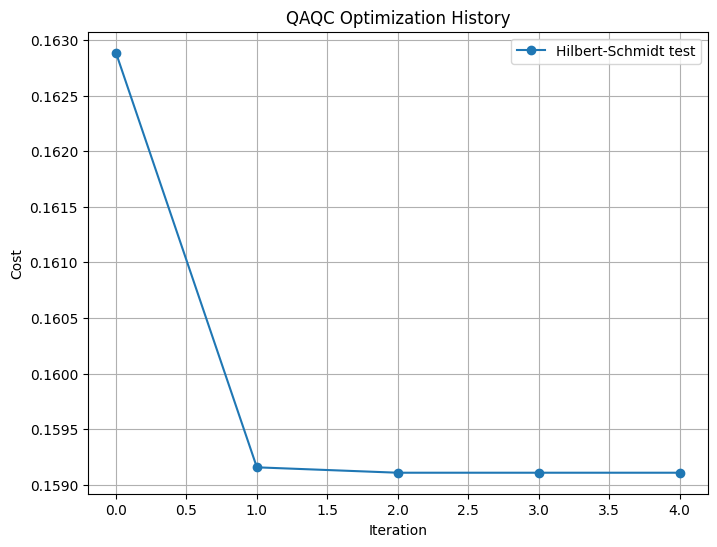

In [57]:
import matplotlib.pyplot as plt

# Assuming compilation_result contains some metrics to plot
# Extracting example data (replace with actual data from compilation_result)
iterations = range(len(compilation_result.cost_function_history[1:]))
costs = compilation_result.cost_function_history[1:]

# Plotting the cost history
plt.figure(figsize=(8, 6))
plt.plot(iterations, costs, marker='o', label='Hilbert-Schmidt test')
plt.title('QAQC Optimization History')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

## Tools for resource analysis

We can analyze the run-time on a quantum device and the fidelity

In [58]:
N_SHOTS = 1000

analysis = qaqc.analyze(time_evo_circuit_factory, ansatz, compilation_result, ftqc_vm.analyze, N_SHOTS, evolution_time=0.1)

print(f"Algorithm runtime: {analysis.total_latency.in_ns()*1e-9/3600} h, minimum fidelity: {min(analysis.circuit_fidelities.values())}")

Algorithm runtime: 25.196208333333335 h, minimum fidelity: 0.9996428778397548


## Ground state energy estimation

We can perform ground state energy estimation using the statistical phase estimation algorithm, which uses time-evolution with the Hadamard test to resolve eigenenergies. We provide classes that facilitate the Hadamard test by quantum circuit sampling.

In [59]:
from quri_algo.core.estimator.time_evolution.trotter import (
    TrotterTimeEvolutionHadamardTest
)
trotter_time_evolution_estimator = TrotterTimeEvolutionHadamardTest(
    hamiltonian_input, ftqc_vm.sample, n_trotter=N_TROTTER
)

In addition a trial state must be provided as input for the algorithm. SPE relies on trial states that overlap well with the actual ground state.

In [ ]:
from quri_parts.core.state import quantum_state

state = quantum_state(QUBIT_COUNT,bits=0b0000)

Before continuing we obtain the analytical solution

In [61]:
import numpy as np
from quri_parts.core.operator import get_sparse_matrix

vals, vecs = np.linalg.eigh(get_sparse_matrix(hamiltonian).toarray())

Since we use the `0b0000` computational basis state The overlap is found simply by

In [100]:
np.abs(vecs[0][0])**2

0.813445895443181

This is a decent situation for SPE

In [94]:
from quri_algo.algo.phase_estimation.spe.lt22 import SingleSignalLT22GSEE
from quri_algo.algo.phase_estimation.spe import StepFunctionParam
D_MAX = 1000
DELTA = 1e-5
N_SAMPLE = 100000

signal_param = StepFunctionParam(d=D_MAX, delta=DELTA, n_sample=N_SAMPLE)

TAU = 1 / 200
ETA = 0.5

lt22_algorithm = SingleSignalLT22GSEE(trotter_time_evolution_estimator, tau=TAU)

spe_result = lt22_algorithm(state, signal_param, ETA)
lt22_gs_energy = spe_result.phase / TAU
pprint(spe_result)
print("Obtained SPE energy: ", lt22_gs_energy)
print("Error: ", np.abs(lt22_gs_energy - np.min(vals)))

SPEResult(phase=-0.023739285733119952,
          signal_functions=[<quri_algo.algo.phase_estimation.spe.utils.signal.SPEDiscreteSignalFunction object at 0x7393545de8d0>])
Obtained SPE energy:  -4.74785714662399
Error:  0.010913336519643657
